In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import pandas as pd
from PIL import Image
import urllib
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Reading the datasets


In [3]:
train_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv')
test_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv')

# Defining the train and test directory path    </div>


In [4]:
train_dir = "/kaggle/input/signature-verification-dataset/sign_data/train"
test_dir = "/kaggle/input/signature-verification-dataset/sign_data/test"

# Defining data loader class    </div>


In [5]:
class DataLoader:
  #constructor
  def __init__(self, dataset, batch_size,dir):
    self.dataset = dataset
    self.batch_size = batch_size
    self.dir = dir
  #shuffler
  def shuffle(self):
    return self.dataset.sample(frac=1)
  #generator
  def datagen(self):
    num_samples = len(self.dataset)
    while True:
        # shuffling the samples
        self.dataset = self.shuffle()
        for batch in range(1, num_samples, self.batch_size):
            image1_batch_samples = self.dir + "/" + self.dataset.iloc[:, 0][batch:batch + self.batch_size]
            image2_batch_samples = self.dir + "/" + self.dataset.iloc[:, 1][batch:batch + self.batch_size]
            label_batch_samples = self.dataset.iloc[:, 2][batch:batch + self.batch_size]
            Image1, Image2, Label = [], [], []
            for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                # append them to Images directly
                image1_data = Image.open(image1)
                image2_data = Image.open(image2)
                # resizing the images
                image1_data = image1_data.resize((112, 112))
                image2_data = image2_data.resize((112, 112))
                # converting to array
                image1_data = img_to_array(image1_data)
                image2_data = img_to_array(image2_data)
                Image1.append(image1_data)
                Image2.append(image2_data)
                Label.append(label)
            # convert each list to numpy arrays to ensure that they get processed by fit function
            Image1 = np.asarray(Image1).astype(np.float32)
            Image2 = np.asarray(Image2).astype(np.float32)
            Label = np.asarray(Label).astype(np.float32)
            yield [Image1, Image2], Label


# Splitting the data into train & val set


In [7]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)


# creating dataloaders</div>


In [8]:
train_gen= DataLoader(train_set,1024,train_dir)
val_gen = DataLoader(val_set,1024,train_dir)

# Performing sanity check of the dataloader    </div>


In [10]:
train_batch = next(train_gen.datagen())
print("Train batch images shape:", train_batch[0][0].shape, train_batch[0][1].shape)
print("Train batch labels shape:", train_batch[1].shape)


Train batch images shape: (1024, 112, 112, 3) (1024, 112, 112, 3)
Train batch labels shape: (1024,)


# Defining custom siamese model architecture    </div>


In [11]:
def custom_siamese_model(input_shape):
    input1 = Input(input_shape)
    input2 = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Call the model with the inputs
    embedding1 = model(input1)
    embedding2 = model(input2)

    loss_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    manhattan_distance = loss_layer([embedding1, embedding2])
    output = Dense(1, activation='sigmoid')(manhattan_distance)
    network = Model(inputs=[input1, input2], outputs=output)
    return network

# Instantiating early stopper with custom callbacks    </div>


In [12]:
early_stopper =  EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1)
custom_callback = [early_stopper]

# Instantiating model


In [13]:
model = custom_siamese_model((112,112,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          1802016     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

# Defining the model and compiling it</div>


In [14]:
optimizer = Adam(lr = 1e-4)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])


# Training the model for 5 epochs

In [15]:
print("Initializing Training !!")
history = model.fit_generator(
    train_gen.datagen(),
    verbose=1,
    steps_per_epoch=100,  # set appropriate steps_per_epoch
    epochs=5,
    validation_data=val_gen.datagen(),
    validation_steps=100,  # set appropriate validation_steps
    callbacks=custom_callback
)


Initializing Training !!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":


Epoch 1/5
100/100 [==============================] - 3802s 38s/step - loss: 1.7737 - accuracy: 0.5351 - val_loss: 0.6411 - val_accuracy: 0.7602
Epoch 2/5
100/100 [==============================] - 3787s 38s/step - loss: 0.4486 - accuracy: 0.7981 - val_loss: 0.5717 - val_accuracy: 0.6325
Epoch 3/5
100/100 [==============================] - 3771s 38s/step - loss: 0.1903 - accuracy: 0.9273 - val_loss: 0.4491 - val_accuracy: 0.7082
Epoch 4/5
100/100 [==============================] - 3748s 38s/step - loss: 0.0613 - accuracy: 0.9806 - val_loss: 0.2340 - val_accuracy: 0.8976
Epoch 5/5
100/100 [==============================] - 3750s 38s/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.1104 - val_accuracy: 0.9781


# Plotting the accuracy and loss plots


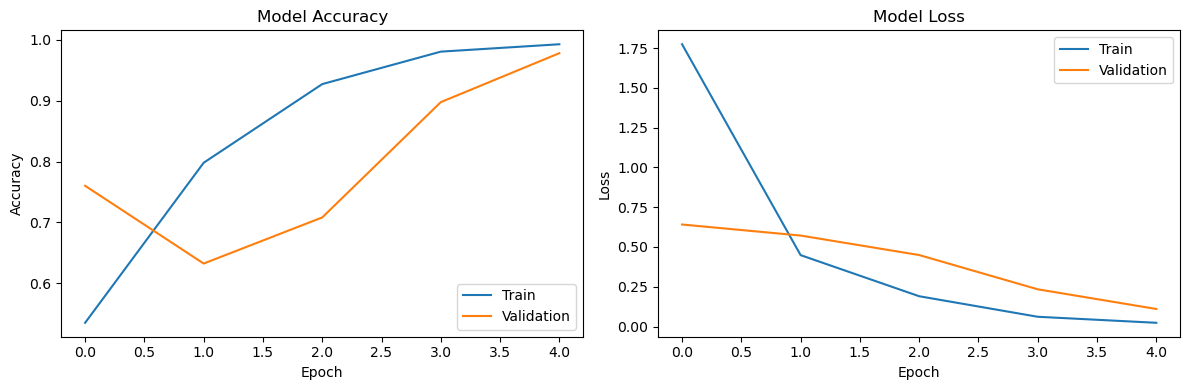

In [18]:
history_keys = history.history.keys()

plt.figure(figsize=(12, 4))

# Plot the accuracy curves
if 'accuracy' in history_keys and 'val_accuracy' in history_keys:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

# Plot the loss curves
if 'loss' in history_keys and 'val_loss' in history_keys:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Inferencing the trained model on original and forged images    </div>


1/1 [==============================] - 0s 31ms/step
Similarity Score: 0.9999999


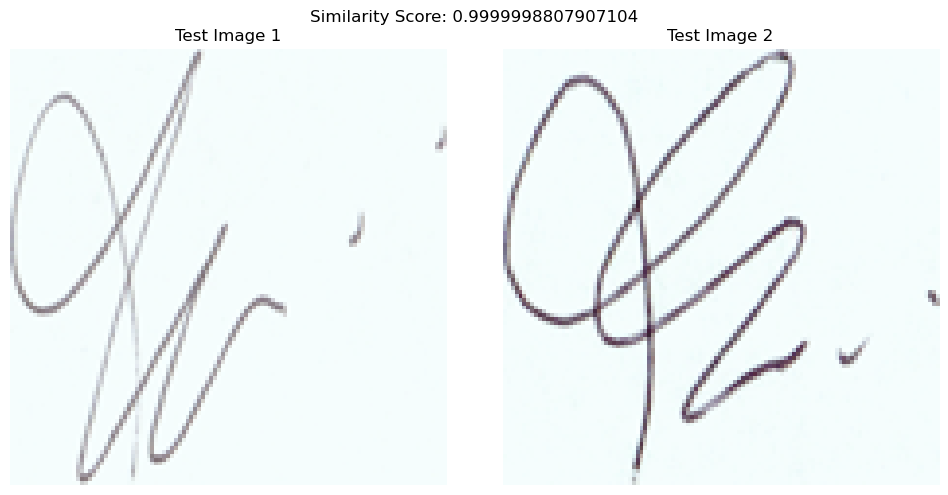

In [19]:
# Define the paths to the test images
test_image1_path = '/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png'
test_image2_path = '/kaggle/input/signature-verification-dataset/sign_data/test/049_forg/01_0114049.PNG'

# Load and preprocess the test images
test_image1 = Image.open(test_image1_path)
test_image1 = test_image1.resize((112, 112))
test_image1 = img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis=0)
test_image1 = test_image1.astype('float32')

test_image2 = Image.open(test_image2_path)
test_image2 = test_image2.resize((112, 112))
test_image2 = img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis=0)
test_image2 = test_image2.astype('float32')

# Perform inference on the test images
prediction = model.predict([test_image1, test_image2])

# Print the similarity score
similarity_score = prediction[0][0]
print('Similarity Score:', similarity_score)

# Display the test images with the similarity score as legend
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image1[0].astype('uint8'))
plt.title('Test Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image2[0].astype('uint8'))
plt.title('Test Image 2')
plt.axis('off')

plt.suptitle(f'Similarity Score: {similarity_score}', fontsize=12)
plt.tight_layout()
plt.show()